# Project 2 Summary

Our newly established BNPL firm can only onboard at most **100 < X** number of merchants every year due
to limited resources. This project aims to develop a highly interpretable and robust ranking system with insights to assist the firm in finding the ideal merchants to **boost the firm's growth and exposure**.

This notebook details the general **EDA, preprocessing, and modelling processes** involved in the final product. There is also a section dedicated to various research, analysis and methods that did not make it into the final product due to being too complex or resulting in unfruitful findings.

<div class="alert alert-block alert-warning">
<b>Note:</b> Please run the script first if you wish to reproduce the outputs in this notebook.
</div>


# Contents
* ### [Exploratory Data Analysis](#eda)
  > ### [Datasets](#datasets)
  > ### [Issues](#issues)
  > ### [Initial Findings](#findings)
* ### [Preprocessing and Feature Engineering](#preprocessing)
  > ### [Modelling Consumers' Daily Fraud Rate](#fraud)
  > ### [Removing Transaction Outliers](#outliers)
  > ### [Extract Merchants' Information](#Extract)
  > ### [Compute Merchants' Performance and Customer Base Metrics](#compute-metrics)
* ### [ETL Pipeline](#etl)

* ### [Merchants' Segmentation by Industries](#industry)
  > ### [Segments Definition](#definitions)
  > ### [Analysis](#segmentanalysis)
  > ### [Final Selection](#selections)
* ### [Ensemble-Averaging Ranking Model](#ensemble-ranking)
* ### [Top Merchants](#result)
  > ### [Top 100 Merchants Overall](#top-100)
  > ### [Top 10 Merchants by Segment](#top-10)
  > ### [Trend Analysis](#trend)
* ### [Assumptions, Limitations and Future Works](#limitations)
* ### [Appendix](#appendix)
<br>

***

# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

# Set working directory to root directory
path = os.path.normpath(os.getcwd())
if path.split(os.sep)[-1] != 'generic-buy-now-pay-later-project-group-19':
    os.chdir("..")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import IntegerType

%matplotlib inline

    
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.broadcastTimeout", -1)
    .getOrCreate()
)

22/10/16 23:35:54 WARN Utils: Your hostname, Polaris resolves to a loopback address: 127.0.1.1; using 172.25.96.154 instead (on interface eth0)
22/10/16 23:35:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/10/16 23:35:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/10/16 23:35:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/

Using Python version 3.8.10 (default, Jun 22 2022 20:18:18)
Spark context Web UI available at http://172.25.96.154:4041
Spark context available as 'sc' (master = local[*], app id = local-1665923756444).
SparkSession available as 'spark'.
22/10/16 23:35:58 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# <a name="eda"></a>Exploratory Data Analysis

This section explores the distribution and shape of the transactions, merchants, customers as well as the external datasets.

## <a name="datasets"></a>Datasets 

In [2]:
# Reading all datasets from the database
consumer = spark.read.option("delimiter", "|").csv('data/tables/tbl_consumer.csv', header = True)

transaction_1 = spark.read.parquet("data/tables/transactions_20210228_20210827_snapshot")
transaction_2 = spark.read.parquet("data/tables/transactions_20210828_20220227_snapshot/")
transaction_3 = spark.read.parquet("data/tables/transactions_20220228_20220828_snapshot/")
transaction = transaction_1.union(transaction_2).union(transaction_3)

merchant = spark.read.parquet("data/tables/tbl_merchants.parquet")

user_detail = spark.read.parquet("data/tables/consumer_user_details.parquet")

# Reading the external datasets that complement our analysis
census = pd.read_csv("data/tables/POA/AUS/2021Census_G01_AUST_POA.csv")

In [3]:
# Shapes of datasets
print(f"Shape of datasets (No. Rows, No. Columns): \n\n \
      \t Transaction : {(transaction.count(), len(transaction.columns))} \n \
      \t Merchants   : {(merchant.count(), len(merchant.columns))} \n \
      \t Consumers   : {(consumer.count(), len(consumer.columns))} \n \
      \t User Details: {(user_detail.count(), len(user_detail.columns))} \n ")

Shape of datasets (No. Rows, No. Columns): 

       	 Transaction : (14195505, 5) 
       	 Merchants   : (4026, 3) 
       	 Consumers   : (499999, 6) 
       	 User Details: (499999, 2) 
 


## <a name="issues"></a>Issues and resolutions

### Issue 1: Found Missing Merchant ABN Data in Transactions

In [4]:
# Find percentage of merchants missing from the merchant datasets
transaction_merchant_abn = set(transaction.select('merchant_abn')
                                          .distinct()
                                          .toPandas()['merchant_abn']
                                          .to_list())

merchant_abn = set(merchant.toPandas()['merchant_abn'].unique())

missing_merchants = len(transaction_merchant_abn) - \
                    len(transaction_merchant_abn.intersection(merchant_abn))

print(f"Number of missing merchants data: {missing_merchants} \
        ({(missing_merchants/len(transaction_merchant_abn)*100):.2f}%)")

Number of missing merchants data: 396         (8.96%)


**Solution** - Discard their records as we do not have crucial information such as **Revenue Level**, **Take Rate** and **Tags/Industries**. We would need at least the tags/industries information to be able to cluster and estimate the take rate for the merchant.
<br>
<br>

### Issue 2: Post Codes Discrepancies When Joining with ABS Datasets

In [5]:
# Find percentage of postcodes that appear in consumer but not in abs dataset
abs_postcode = set(census['POA_CODE_2021'].apply(lambda x: int(x[3:])).tolist())
consumer_postcode = set(pd.to_numeric(consumer.select('postcode')
                                              .toPandas()['postcode'])
                                              .tolist())

missing_postcodes = len(consumer_postcode) - len(abs_postcode)

print(f"Number of missing postcodes in ABS dataset: {missing_postcodes} \
        ({(missing_postcodes/len(consumer_postcode)*100):.2f}%)")

Number of missing postcodes in ABS dataset: 524         (16.55%)


**Solution** - Reduce granularity by **grouping postcodes** based on **Statistical Area 2 (SA2) Codes**. This allows us to match much more consumers data to the ABS dataset. 

<!-- It turns out after grouping by SA2 region code, the SA2 code in `Consumer` dataset fully matched the SA2 code in the external postcode-SA2 dataset. Thus, we will have full information on SA2 code grouping on the consumer dataset. -->
<br>
<br>

### <a name="skewed"></a>Issue 3: Highly Skewed Distribution of Dollar Value in Transaction Dataset

In [6]:
# Find max and min dollar value per order
min_value = transaction.agg({"dollar_value": "min"}).collect()[0][0]
max_value = transaction.agg({"dollar_value": "max"}).collect()[0][0]

print(f"Min value per order: ${min_value}\nMax value per order: ${max_value}")

Min value per order: $9.756658099412162e-08
Max value per order: $105193.88578925544


Text(0.5, 0, 'Dollar Value ($)')

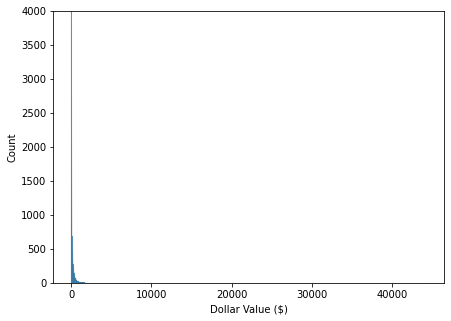

In [7]:
# Plot a sample of transaction dollar value distribution
sample = transaction.sample(0.0075).toPandas()
fig, ax = plt.subplots(1, figsize=(7, 5))
sns.histplot(sample['dollar_value'])
plt.ylim([0,4000])
plt.xlabel('Dollar Value ($)')

Transaction value per order is not capped with values as low as \\$0 and high as \$105193.9 in a single order. These transactions are clearly not reflective of our future transactions (BNPL firms typically set a upper limit to avoid overly high-value risky transactions), so we will remove these.

**Solution** - Outlier detection and removal. Using the generic outlier filtering method (filtering out `dollar_value` that lies outside the range of ($1.5-IQR, 1.5+IQR$) on the log-transformed `dollar_value` (log-transform to make the distribution more symmetric before applying the IQR filtering method) followed by reverting the transformation to obtain the lower and upper bound of transaction.

Text(0.5, 0, 'log(Dollar Value)')

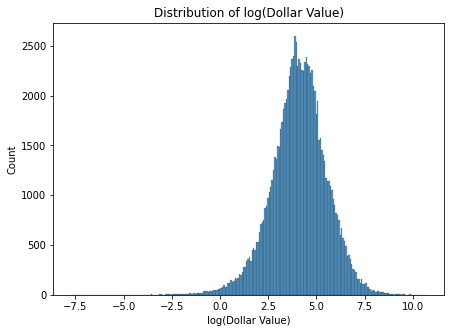

In [8]:
fig, ax = plt.subplots(1, figsize=(7, 5))
sns.histplot(np.log(sample['dollar_value']))
plt.title('Distribution of log(Dollar Value)')
plt.xlabel('log(Dollar Value)')

In [9]:
# Find new lower and upper bound for transactions
transaction1 = (transaction.select('dollar_value')
                           .withColumn('log_dollar_value', F.log(F.col('dollar_value'))))

# Find the lower and upper bound from the log-transformed dollar value
lwr, upr = transaction1.approxQuantile('log_dollar_value', [0.25, 0.75], 0.01)
iqr = upr - lwr
lwr_bound = lwr - 1.5 * iqr
upr_bound = upr + 1.5 * iqr

# Revert the log-transformation to get the actual value of the bounds
lwr_bound, upr_bound = np.exp(lwr_bound), np.exp(upr_bound)
print(f"Range of Accepted Transaction Value per order: ${lwr_bound} - ${upr_bound}")


Range of Accepted Transaction Value per order: $1.7989788333828576 - $2086.4549505058903


The `dollar_value` range per transaction is now much smaller and we found that it is comparable to the upper bound with the **industry leading competitor (Afterpay)** which has a **maximum limit per transaction of $1500**.
<br>
<br>

### Issue 4: Missing information on weekly income when joining the consumers' SA2 region codes to the respective median weekly personal income in the region

In [10]:
# Read the consumer joined sa2 and abs census joined sa2 datasets
consumer_region_sa2 = (spark.read
                            .parquet("data/curated/consumer_regions"))

census_with_sa2 = (spark.read
                        .parquet("data/curated/census")
                        .select(['sa2_code','median_tot_prsnl_inc_weekly']))

# Find percentage of consumer without weekly income information
consumer_join_census = consumer_region_sa2.join(census_with_sa2, 'sa2_code', how='left')

# 1 consumer's postcode might belong to up to 3 different SA2 codes, so we take
# the average of these 3 regions' income
consumer_join_census = (consumer_join_census.groupby('consumer_id')
                                            .agg(F.mean('median_tot_prsnl_inc_weekly')
                                                  .alias('weekly_income')))

missing_income_info = consumer_join_census.select(
            F.count(
                F.when(
                    F.isnull('weekly_income'), 1
                )
            )
        ).collect()[0][0]

print(f"Number of Customer with Missing Income Info: {missing_income_info} \
        ({(missing_income_info/consumer.count())*100:.2f}%)")


Number of Customer with Missing Income Info: 58314         (11.66%)


**Solution** - Since there are only about 11.7\% missing weekly income in consumer data, we decided to **impute** the missing values based on the **median weekly income of all consumers**.


In [11]:
print(f"Median Consumer Income for Imputation: ${consumer_join_census.approxQuantile('weekly_income', [0.5], 0.001)[0]}")

Median Consumer Income for Imputation: $752.0


<br>
<br>

## <a name="findings"></a>Other Findings: 
### 1. Some merchants have high but inconsistent monthly revenue

In [12]:
# Show the two merchants who have similar magnitude of sales but widely different
# monthly sales deviation
merchant_sales = spark.read.parquet("data/curated/merchant_daily_sales")

merchant_1 = (merchant_sales.where(F.col('merchant_abn')==36758807067)
                            .groupby(F.date_trunc("month",
                                                  F.col('order_datetime')))
                            .agg(F.sum("tot_dollar_value"))
                            .toPandas())

merchant_2 = (merchant_sales.where(F.col('merchant_abn')==78916025936)
                            .groupby(F.date_trunc("month",
                                                  F.col('order_datetime')))
                            .agg(F.sum("tot_dollar_value"))
                            .toPandas())

merchant_1['month_year'] = merchant_1['date_trunc(month, order_datetime)'].dt.strftime('%Y-%m')
merchant_1 = merchant_1.sort_values('month_year')
merchant_2['month_year'] = merchant_2['date_trunc(month, order_datetime)'].dt.strftime('%Y-%m')
merchant_2 = merchant_2.sort_values('month_year')


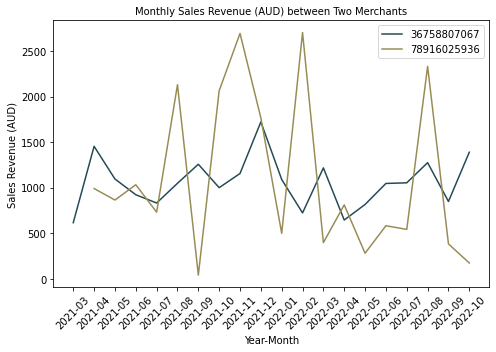

In [13]:
# Plot two merchants with different deviation in monthly sales revenue
fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.lineplot(merchant_1['month_year'],merchant_1['sum(tot_dollar_value)'], color='#234a55', sort=True)
ax = sns.lineplot(merchant_2['month_year'],merchant_2['sum(tot_dollar_value)'], color='#988c55', sort=True)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Sales Revenue (AUD)', fontsize=10)
ax.set_xlabel('Year-Month', fontsize=10)

plt.xticks(rotation=45)
plt.legend(['36758807067','78916025936'], fontsize=10)
plt.title("Monthly Sales Revenue (AUD) between Two Merchants", fontsize=10)

fig.tight_layout()
fig.savefig('plots/stable_merchant.png', dpi=300)


The merchant with ABN 78916025936 has **high variations in their earnings** on average (**unstable sales performance**) to the point where they had close to 0 sales revenue on 2021-09. The merchant with ABN 36758807067 has a more stable monthly revenue in comparison, which means we can expect to receive a consistent monthly commission from them. As a newly established firm, we would want to **avoid merchants** with inconsistent monthly revenue.
<br>
<br>

### 2. Some merchants have high average customer spending but low customer base median weekly income

In [14]:
# Find merchants with large difference in average customer spending and median customer weekly income
merchant_df = pd.read_parquet("data/curated/final_merchant_statistics")
income = merchant_df.sort_values('median_weekly_income', ascending=True)[:3][['merchant_abn','median_weekly_income','avg_tot_dollar_value_customers']]
income

,merchant_abn,median_weekly_income,avg_tot_dollar_value_customers
635,53877856360,435.500000,2045.324480
715,83199298021,499.666667,1971.663730
276,97590358496,561.000000,1129.362111


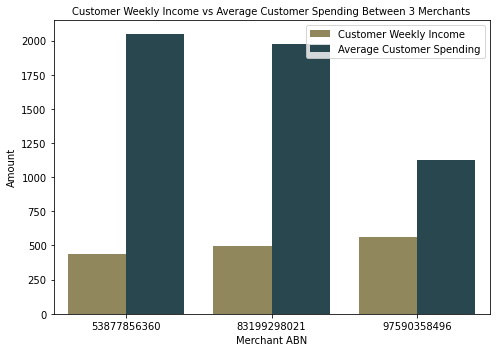

In [15]:
# Plot the difference in average customer spending and income
data = {'Merchant ABN':[53877856360,83199298021,97590358496,53877856360,83199298021,97590358496],
        'variables':['Customer Weekly Income','Customer Weekly Income','Customer Weekly Income', \
               'Average Customer Spending','Average Customer Spending','Average Customer Spending'],
        'Amount':[435.5,499.67,561,2045.32, 1971.66,1129.36]}

data = pd.DataFrame(data)

fig, ax = plt.subplots(1, figsize=(7, 5))
sns.barplot(x='Merchant ABN',y='Amount', hue='variables', data=data, palette=['#988c55','#234a55'])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], fontsize=10)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Amount', fontsize=10)
ax.set_xlabel('Merchant ABN', fontsize=10)
plt.title('Customer Weekly Income vs Average Customer Spending Between 3 Merchants', fontsize=10)

fig.tight_layout()
fig.savefig('plots/income_spending.png', dpi=300)

The first two merchants have high average customer spending (about \\$2000, split into 5 instalments = \$400/week), but their median customer income is only about \\$400+/week. Taking Australian living costs into account, they **might not be able to afford their weekly instalments**. Thus, we want to avoid merchants who tend to attract customers with high credit risk.
<br>
<br>

### 3. Some merchants have high number of returning customers

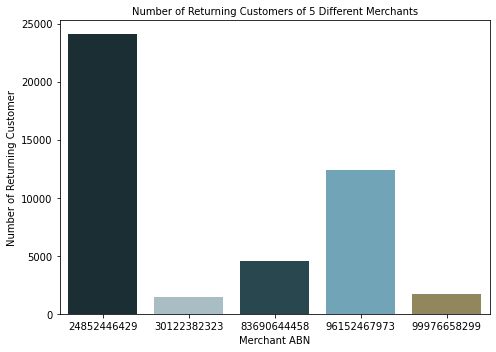

In [16]:
# Plot several merchants with different number of returning customers
returning_cust_abn = [24852446429, 99976658299, 83690644458, 30122382323,96152467973]
palette = ['#173038','#a4c1c8','#234a55','#66aac1','#988c55','#CFCAB4','#4c462a','#86b093']

fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.barplot(x='merchant_abn', y='returning_customers', 
                 data=merchant_df[merchant_df['merchant_abn'].isin(returning_cust_abn)],
                 palette=palette)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Number of Returning Customer', fontsize=10)
ax.set_xlabel('Merchant ABN', fontsize=10)

plt.title("Number of Returning Customers of 5 Different Merchants", fontsize=10)

fig.tight_layout()
fig.savefig('plots/returning_cust_merchants.png', dpi=300)

We believe this is an important metric to consider as we could potentially **increase our exposure and customer conversion rate** (customers convert from using competitors platforms' to using our firm's BNPL platform) by onboarding merchants with high returning customers.
<br>
<br>

### 4. Merchants from the list have customers from all different regions across Australia

The following plot shows the number of orders by region (2021/02 - 2022/10) from all merchants who are willing to onboard with us.

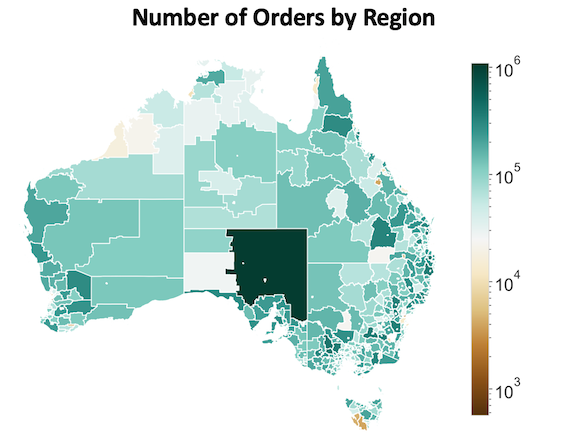

We observe that the merchants have a **very wide coverage** across different regions in Australia, which implies that if merchants are selected optimally, we can **maximize our firm's brand visibility across Australia**. Due to large amount of code needed to produce the plot, the code is excluded from this notebook to improve readability.
<br>
<br>

### <a name="fraud-finding"></a>5. Consumers' fraud rate directly correlates to their total spendings on the day 

In [17]:
# Find customer fraud probability and their spending patterns on that day
cust_fraud = spark.read.csv("data/tables/consumer_fraud_probability.csv", header=True)
tran_dataset_1 = (transaction_1.groupby(['user_id','order_datetime'])
                               .agg({'dollar_value':'sum',
                                     'order_id':'count'}))
tran_dataset_2 = (transaction_2.groupby(['user_id','order_datetime'])
                               .agg({'dollar_value':'sum',
                                     'order_id':'count'}))
tran_dataset_3 = (transaction_3.groupby(['user_id','order_datetime'])
                               .agg({'dollar_value':'sum',
                                     'order_id':'count'}))

cust_fraud_1 = (cust_fraud.join(tran_dataset_1, ['user_id', 'order_datetime'], how='inner')
                          .toPandas())

cust_fraud_2 = (cust_fraud.join(tran_dataset_2, ['user_id', 'order_datetime'], how='inner')
                          .toPandas())

cust_fraud_3 = (cust_fraud.join(tran_dataset_3, ['user_id', 'order_datetime'], how='inner')
                          .toPandas())

cust_fraud_1['fraud_probability'] = pd.to_numeric(cust_fraud_1['fraud_probability'])
cust_fraud_2['fraud_probability'] = pd.to_numeric(cust_fraud_2['fraud_probability'])
cust_fraud_3['fraud_probability'] = pd.to_numeric(cust_fraud_3['fraud_probability'])

22/10/16 23:37:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/16 23:37:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/16 23:37:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/16 23:37:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/16 23:37:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/16 23:37:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/16 23:37:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/16 23:37:00 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/10/16 23:37:00 WARN RowBasedKeyValueBatch: Calling spill() on

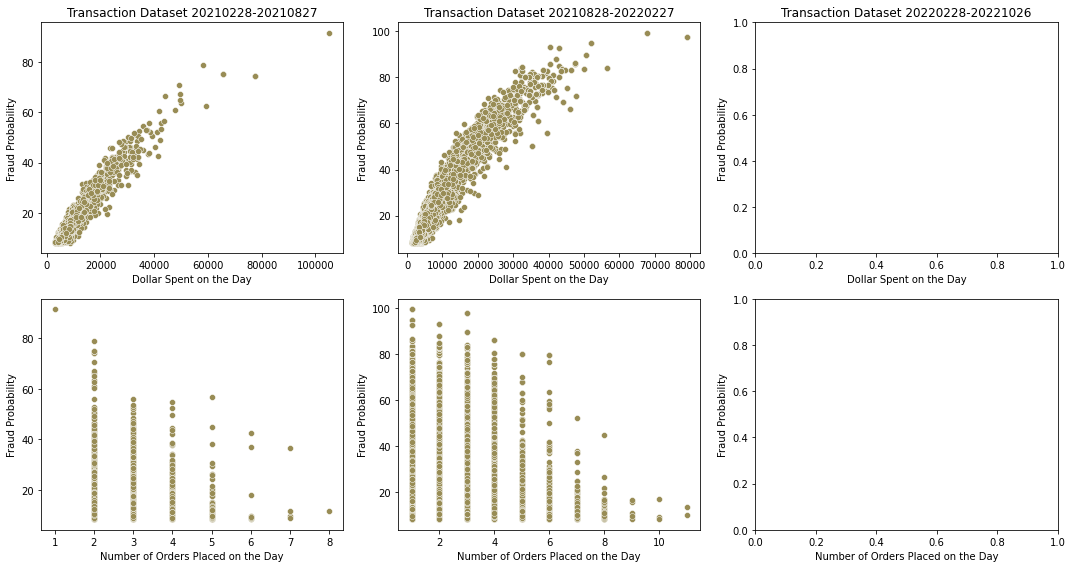

In [18]:
# Plot customer's total spending and number of order placed on a day vs the customer's fraud
# prob on the same day
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
cust_fraud = [cust_fraud_1, cust_fraud_2, cust_fraud_3]

i=0
for data in cust_fraud:
    sns.scatterplot(x='sum(dollar_value)',y='fraud_probability', data=data, color='#988c55', ax=ax[0,i])
    sns.scatterplot(x='count(order_id)',y='fraud_probability', data=data, color='#988c55', ax=ax[1,i])
    i+=1

ax[0,0].title.set_text('Transaction Dataset 20210228-20210827')
ax[0,1].title.set_text('Transaction Dataset 20210828-20220227')
ax[0,2].title.set_text('Transaction Dataset 20220228-20221026')
plt.setp(ax[0,:], ylabel='Fraud Probability', xlabel='Dollar Spent on the Day')
plt.setp(ax[1,:], ylabel='Fraud Probability', xlabel='Number of Orders Placed on the Day')
fig.tight_layout()
fig.savefig('plots/cust_fraud_daily.png', dpi=300)

Based on the plots above, we clearly see a **strong linear relationship** between **consumers' daily fraud rate** and their **total spending on the day** from the given customer fraud data. We also noticed that the customer fraud labelling was only run on a subsample of the transaction data (e.g. there was zero customer daily fraud info given for the third dataset as shown on the third column plots).
<br>
<br>

### 6. No major patterns or relationships found using the merchant fraud dataset

Using the merchant fraud dataset, we **plotted various metrics** such as sales revenue, number of orders, andaverage value of each order on the day **against the daily merchants' fraud rate** and were unable to find any strong **patterns and/or correlations**. Besides, there were only 61 unique `merchants_abn` out of 4026 valid merchants (**1.5\% of the overall merchants**) fraud data available. As such, we decided to discard the merchant fraud data from our final analysis to avoid adding unnecessary noise to the data.
<br>
<br>
<br>
<br>


# <a name="preprocessing"></a>Preprocessing and Feature Engineering

This section details the **extract, transform and load (ETL) processes** done in the final product.

## <a name="fraud"></a>Modelling Consumers Daily Fraud Rate

### Predicting customer's daily fraud rate

Based on the findings ([5.](#fraud-finding)), we trained a **Linear Regression model** on the given consumer fraud dataset and the unfiltered transaction datasets. We then use this model to **predict the remaining consumers' daily fraud rate in the transaction datasets** that was not in the consumer fraud dataset.

In [19]:
from statsmodels.formula.api import ols, glm
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

cust_fraud_join = pd.concat(cust_fraud).rename({'sum(dollar_value)':'total_spent',
                                                'count(order_id)':'total_orders'}, axis=1)

fit = ols(
    formula="fraud_probability ~ total_spent + total_orders + total_spent/total_orders",
    data=cust_fraud_join
).fit()

print(fit.summary())

                            OLS Regression Results                            
Dep. Variable:      fraud_probability   R-squared:                       0.818
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                 5.208e+04
Date:                Sun, 16 Oct 2022   Prob (F-statistic):               0.00
Time:                        23:37:04   Log-Likelihood:                -99899.
No. Observations:               34864   AIC:                         1.998e+05
Df Residuals:                   34860   BIC:                         1.998e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

**Note**: `total_order` is **no longer significant at 5\% level**, but the interaction term (`total_spent`/`total_orders`) is. The interaction term explains why the scatter plot has a log like shape. When total spending is the same, less average dollar value per order means less fraud probability.

Finally, we used the following **Linear Model** to predict the remaining consumers' daily fraud rate in the transaction datasets: 

$$\text{Fraud Probability on the day} \sim \text{Total Spent on the day} + \frac{\text{Total Spent on the day}}{\text{Total Orders made on the day}}$$

In [20]:
final_fit = ols(
    formula="fraud_probability ~ total_spent + total_spent/total_orders",
    data=cust_fraud_join
).fit()

print(f"Goodness of fit of the Linear Model (R-squared value): {final_fit.rsquared:.2f}")

Goodness of fit of the Linear Model (R-squared value): 0.82


The model has high $R^2\;(\approx1)$ value, indicating that the model **fits really well** to the existing customer fraud data.
<br>
<br>


### Fraud-related metrics development

Assuming that if it turns out that the consumer committed fraud on the day, we/merchant **lose the full amount** equals to the **total dollar value** the customer spent on the merchant on the day.

$$\begin{align}
&\text{Earning from Customer } x \text{ on Day }y \\
&=\left\{
\begin{array}{ll}
\text{Total Customer }x\text{ spending on the merchant on day }y & \text{with probability } 1-P(\text{customer }x\text{ fraud rate on day }y) \\
-\text{ Total Customer }x\text{ spending on the merchant on day }y & \text{with probability } P(\text{customer }x \text{ fraud rate on day }y) 
\end{array}
\right.
\end{align}$$

We then create a fraud-discounted revenue metric to encode the fraud information of each merchants' consumer base.

$$\text{Fraud-Discounted Earning from Customer }x\text{ on Day }y = \mathbb{E}\left(\text{Earning from Customer } x \text{ on Day }y\right)$$

$$\text{Fraud-Discounted Revenue of Merchant} = \sum_{y=1}^l\sum_{x=1}^{n}\mathbb{E}\left(\text{Earning from Customer } x \text{ on Day }y\right)$$
where $l$ denotes the last day of sales in the transaction data, $n$ denotes the number of customer on day $y$

The intuition behind this metric is that if **most customers from merchant $z$ has high fraud rate** (eg. 80\%), then

$$\begin{align}
&\mathbb{E}\left(\text{Earning from Customer } x \text{ on Day }y\right)<0\\
&\implies\text{Fraud-Discounted Earning from Customer }x\text{ on Day }y < 0\\
&\implies\text{Fraud-Discounted Revenue of Merchant} < 0
\end{align}$$

essentially resulting in **more losses than gain** in onboarding such merchants.

In [21]:
# Example of merchants after discounting revenue by customer fraud rate
merchant_df['discounted_amt'] = merchant_df['tot_dollar_value'] - merchant_df['tot_discounted_value']
merchant_df[['merchant_abn','tot_dollar_value','tot_discounted_value','discounted_amt']].head()

,merchant_abn,tot_dollar_value,tot_discounted_value,discounted_amt
0,10023283211,7.032777e+05,6.554602e+05,47817.500735
1,10346855916,6.775178e+03,6.166115e+03,609.063100
2,10385163239,2.519346e+04,2.342538e+04,1768.086220
3,10648956813,1.419600e+06,1.329625e+06,89974.922213
4,10714068705,4.355100e+05,4.067113e+05,28798.609213


<br>

## <a name="outliers"></a>Removing outliers in transaction dataset

Based on the previous findings on the [skewed transaction values in the data](#skewed), we settled on the range of `dollar_value`, and we **removed any transactions that do not lie in this range**. Removing these transactions gives us a **clear view of possible transaction values once we onboarded the merchants**. Limiting transactions to within this range also helps to greatly reduce the risk that our firm has to bear.

In total, x records were discarded in the transaction datasets.
<br>
<br>

## <a name="Extract"></a>Extract and clean merchants' information from the merchant dataset

In [22]:
merchant.limit(1).toPandas()

,name,tags,merchant_abn
0,Felis Limited,"((furniture, home furnishings and equipment sh...",10023283211


The tag column includes information such as the `take_rate`, `revenue_level` and `tags`. Hence, we need to split this information into their respective columns. 

The tags are also generally noisy and uncleaned (e.g. spelling errors, unnecessary punctuations, etc.). Hence, we cleaned tags following the process below:

$$\text{Tokenisation by Commas}\implies\text{Case Standardisation}\implies\text{Punctuations/Number Removal}\implies\text{Spelling Autocorrection}\implies\\\text{Tokens Lemmatisation}$$

### Categorizing merchants' based on tags

After cleaning the tags, we merged the tags for each merchants using `,` as delimiter. Then we used `CountVectorizer` to one-hot-encode the tags for each merchants. An example of the cleaned merchant's table is as follow

In [23]:
merchant_with_tags = spark.read.parquet("data/curated/merchants_with_tags")
merchant_with_tags.limit(5)

22/10/16 23:37:05 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


name,merchant_abn,revenue_level,take_rate,antique_shop_sale,appliance_rent_leasing,art_dealer_gallery,artist_supply_craft_shop,bicycle_shop_sale_service,book,cable,card,clock,computer,computer_peripheral_equipment,computer_programming,data_processing,digital_good_book,equipment,except_appliance,eyeglass,flower,forest_supply,furniture,gift,health_beauty_spa,hobby,home_furnishing_equipment_shop,including_nursery,integrated_system_design_service,jewelry,jewelry_repair_shop,lawn_garden_supply_outlet,manufacturer,motor_vehicle_supply_new_part,movie,music,music_shop_musical_instrument,newspaper,novelty,nursery_stock,office_supply_printing_writing_paper,optical_good,optician,pay_television_radio_service,periodical,piano,repair,restoration_service,satellite,sheet_music,shoe_shop,silverware_shop,software,souvenir_shop,stationery,telecom,tent_owning_shop,tool,toy_game_shop,watch
Odio Tristique Ph...,93712553837,a,5.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Donec Luctus Aliq...,93720983561,c,1.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Quam Quis Diam Co...,93723130289,b,3.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
Justo Praesent Lu...,93726438981,a,5.91,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Tellus Nunc Indus...,93732268717,d,1.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [24]:
# Get the number of individual tags extracted from merchant data
merch_tag = spark.read.parquet("data/curated/merchants_with_tags")

# Exclude name, abn, revenue level and take rate
print(f"Number of individual tag: {len(merch_tag.columns[4:])}")

Number of individual tag: 57


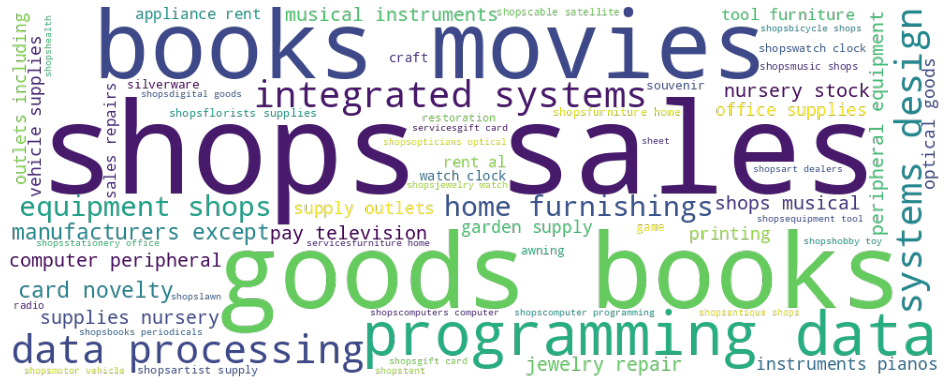

In [25]:
# Plot word cloud
comment_words = ''
 
# iterate through the csv file
for idx, row in merchant_df.iterrows():
     comment_words += row['tag']
        
from wordcloud import WordCloud, STOPWORDS

# Plot the WordCloud image  
wordcloud = WordCloud(mode = "RGBA", width = 1000, height = 400,
                background_color =None,
                min_font_size = 10).generate(comment_words)
   
fig, ax = plt.subplots(1, figsize=(13, 9))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
fig.savefig('plots/tag_cloud.png', transparent=True, dpi=300) 
plt.show()


<br>
<br>

## <a name="compute-metrics"></a>Compute merchants' performance and customer base metrics

After cleaning the dataset, we **aggregated different datasets** to obtain various merchants' metrics. We then narrow down these metrics to find the subset of metrics that address the **4 challenges** that new firms in this industry typically face as follows. Once we have shortlisted the metrics that we deem important for each challenge, we then further narrow down to find metrics within each group that are **least correlated** among the other metric in the same group to **avoid overfitting** or **introducing too much bias** on a certain metrics.

Our final set of **10 metrics** to rank the merchants are as follow:

<!-- **directly/indirectly reflect the merchants' sales performance** as well as their **customers' repayability/credit-reliability**. -->

### 1. <a name="exposure"></a>Exposure and Brand Familiarity
Startups in BNPL suffer from lack of budget in marketing to promote firms' exposure. As such, we want to onboard merchants with **high potential to reach a wider audience**.

- **Number of Sales Region**: Number of SA2 region that the merchant sells to. This directly reflects the **geographical reach** of the merchant. Ideally, to increase our firms' exposure, we would want a merchant with high value in this metric.<br>


- **Number of Unique Customers**: Refers to the number of customers with unique `consumer_id`. This metric indirectly reflects the **exposure that our firm gains when onboarding the merchant**.<br>


- **Number of Returning Customers**: Refers to the number of returning customers (has ordered more than 2 times) of the merchant. This metric reflects the brand familiarity among customers of the merchant. The higher the number of returning customers, the more they will see our brand in the checkout, thus **increasing brand memorability** and **potentially increasing customers' conversion rate**. <br><br>


### 2. <a name="customer-demo"></a>Customer Demographic
Startups in BNPL suffer from a lack of budget in marketing to promote the firm’s exposure. As such, we want to onboard merchants with high potential to reach a wider audience.

- **Median Weekly Income of Consumer Base**: Median weekly income of the consumer base for the merchant. This indirectly tells us the **repayability of the target consumers**. Ideally, the higher the value, the less risky it is for the target consumers to default in instalment payments.<br><br>


### 3. <a name="sales-performance"></a>Merchants' Sales Performance
With limited resources, we need to select merchants such that three forms of positive financial performance are maximized overall: stability and profit potential. Ideally, we’re looking for merchants who maximize these metrics.

<!-- - **Average Daily Revenue**: Average earnings from merchant per day

$$\text{Average Daily Revenue}=\frac{\text{Total revenue}}{\text{Number of days in the transaction data}}$$
<br>
- **Average Daily Order Count**: Average number of orders per day

$$\text{Average Daily Order Count}=\frac{\text{Total number of order}}{\text{Number of days in the transaction data}}$$
<br>
- **Average Value per Order**: Average number of orders per day

$$\text{Average Value per Order}=\frac{\text{Total revenue}}{\text{Total number of orders}}$$
<br>
- **Revenue Level**: Alphabetical order representation of the level of revenue bands (from high to low revenue band)

$$\text{Revenue Level}\in\{a,b,c,d,e\}$$
<br>
- **Average Daily Commission**: Average daily commission that BNPL firm receives if 100\% of the merchants' transaction is paid through the BNPL's platform

$$\text{Average Daily Commission}=\text{Average Daily Revenue}\times\text{Take rate}$$


- **Average Monthly Commission**: Average monthly commission that our firm receives per order from the merchant, assuming 100\% of the merchant's customer base use our platform for payment.

$$\text{Average Commission per Order}=\text{Average Value per Order}\times\text{Take rate}$$

- **Average Customer Spending**: Refers to the average total spending of each customer on the merchant.

$$\text{Average Customer Spending}=\frac{\text{Total Revenue}}{\text{Number of Customer}}$$ -->

- **Average Monthly Commission**: Average monthly commission that our firm receives per order from the merchant, assuming 100\% of the merchant's customer base uses our platform for payment.

$$\text{Average Monthly Commission}=\text{Average Monthly Revenue}\times\text{Take rate}$$<br>


- **Average Monthly Orders**: Average monthly number of orders from the merchant.

$$\text{Average Monthly Orders}=\frac{\text{Total number of order}}{\text{Number of Month in the transaction data}}$$<br>


- **Standard Deviation of Monthly Revenue**: Captures the **average deviation in monthly revenue** of a merchant.
<br>
<br>

### 4. <a name="fraud-transactions"></a>Fraudulent Transactions
Automation allows fraudsters to create tens of thousands of fraudulent consumer accounts with stolen credentials. These fake accounts can be monetized by making purchases without paying the instalments, which incur a loss to the BNPL firm. Hence, we need metrics that gauge the potential fraud risk among a merchant's customer base.
<!-- 
- **Total Discounted Revenue**: Refers to the total revenue of a merchant discounted by fraud probability of their customer base. For intuition and derivation of this metric, check out the [fraud modelling](#fraud) section.<br>

 -->
- **Discounted Average Value per Order**: Refers to the expected average value per order **discounted by the predicted fraud rate**. Intuition is similar to the intuition under [fraud modelling](#fraud) section.<br>


- **Overall Fraud Rate**: Refers to predicted **overall proportion of fraudulent orders** per merchant.<br>


- **Standard Deviation of Discounted Daily Revenue**: Captures the **average deviation in daily discounted revenue** of a merchant.<br>

<br>
<br>

# <a name="etl"></a>ETL Pipeline
This section details the **ETL pipeline** in the final product.

### Preprocessing pipeline

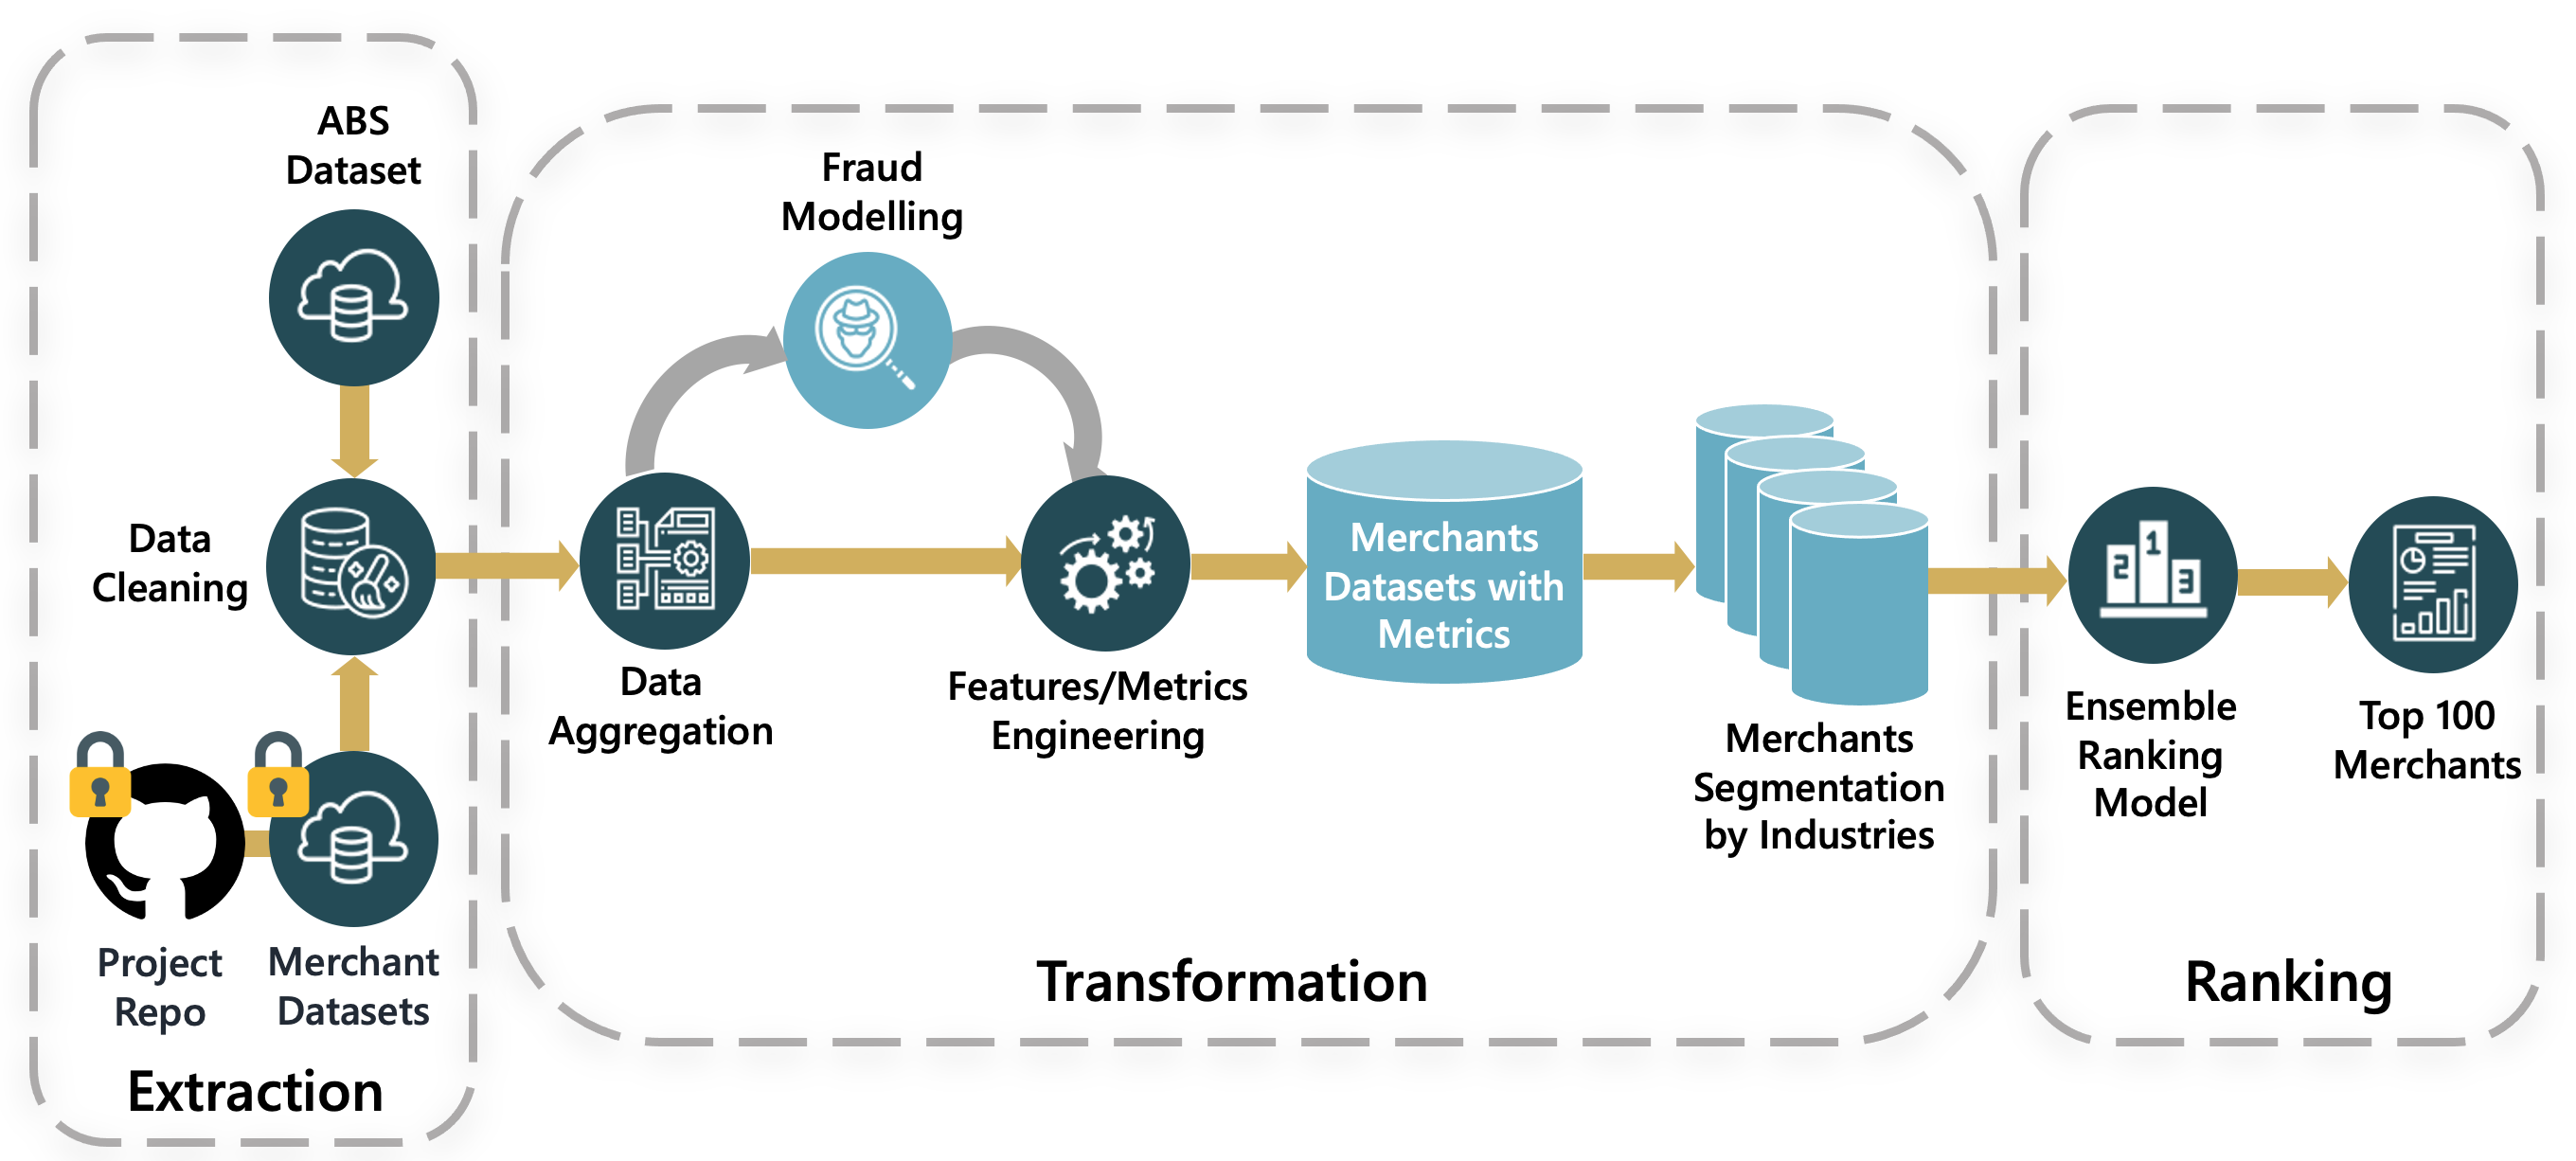

<!-- $$\text{Load Datasets}\implies\text{Basic Data Cleaning}\implies\text{Consumers Daily Fraud Rate Modelling}\cup \text{Transaction Outlier Removal}\cup\text{Merchants' Information Extraction and Wrangling}\implies\text{Various Data Joins and Aggregations}\implies\text{Consumers' Income Imputation}\\\implies\text{Performance Metrics Computation}\implies\text{Final Merchants Statistics}$$ -->

The final merchants statistics table which consists **all merchants' statistics** (not just the final subset used in ranking):

In [26]:
# Show first 5 merchants stats
final_merch_stat = merchant_df.drop('tags', axis=1)
final_merch_stat.head()

,merchant_abn,name,tag,revenue_level,take_rate,tot_dollar_value,avg_dollar_value,stddev_dollar_value,tot_discounted_value,avg_discounted_value,...,commission_avg_tot_discounted_value_daily,commission_stddev_tot_discounted_value_daily,numd_sa2_code,median_weekly_income,returning_customers,unique_customers,avg_tot_dollar_value_customers,stddev_tot_dollar_value_customers,vip_customers,discounted_amt
0,10023283211,Felis Limited,"furniture, home furnishings and equipment shop...",e,0.18,7.032777e+05,215.663205,138.039260,6.554602e+05,200.999758,...,1.946912,0.001963,1717.0,794.816023,11.0,3032.0,231.951752,155.424439,137.0,47817.500735
1,10346855916,Odio Institute,"equipment, tool, furniture, and appliance ren...",b,3.57,6.775178e+03,1129.196413,717.988423,6.166115e+03,1027.685896,...,0.363251,0.149654,7.0,788.166667,0.0,6.0,1129.196413,717.988423,0.0,609.063100
2,10385163239,Sed Et Company,"florists supplies, nursery stock, and flowers",a,6.61,2.519346e+04,340.452204,201.963247,2.342538e+04,316.559147,...,2.555144,0.577294,132.0,797.507171,0.0,73.0,345.115933,203.496326,3.0,1768.086220
3,10648956813,Proin Nisl Institute,"computers, computer peripheral equipment, and ...",a,6.66,1.419600e+06,64.583063,22.112070,1.329625e+06,60.489758,...,146.127145,2.525663,2208.0,825.551750,1574.0,14380.0,98.720466,57.083817,710.0,89974.922213
4,10714068705,Sollicitudin Commodo Ipsum Industries,"furniture, home furnishings and equipment shop...",c,2.51,4.355100e+05,126.675378,104.490307,4.067113e+05,118.298820,...,16.845635,0.252372,1715.0,796.782831,10.0,3221.0,135.209547,113.737044,145.0,28798.609213


In [27]:
# Show first 5 merchants tags
merchant_with_tags.limit(5)

name,merchant_abn,revenue_level,take_rate,antique_shop_sale,appliance_rent_leasing,art_dealer_gallery,artist_supply_craft_shop,bicycle_shop_sale_service,book,cable,card,clock,computer,computer_peripheral_equipment,computer_programming,data_processing,digital_good_book,equipment,except_appliance,eyeglass,flower,forest_supply,furniture,gift,health_beauty_spa,hobby,home_furnishing_equipment_shop,including_nursery,integrated_system_design_service,jewelry,jewelry_repair_shop,lawn_garden_supply_outlet,manufacturer,motor_vehicle_supply_new_part,movie,music,music_shop_musical_instrument,newspaper,novelty,nursery_stock,office_supply_printing_writing_paper,optical_good,optician,pay_television_radio_service,periodical,piano,repair,restoration_service,satellite,sheet_music,shoe_shop,silverware_shop,software,souvenir_shop,stationery,telecom,tent_owning_shop,tool,toy_game_shop,watch
Odio Tristique Ph...,93712553837,a,5.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Donec Luctus Aliq...,93720983561,c,1.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Quam Quis Diam Co...,93723130289,b,3.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
Justo Praesent Lu...,93726438981,a,5.91,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Tellus Nunc Indus...,93732268717,d,1.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In the final merchant stats table, there are merchants whose transactions are all **beyond our specified range** (\\$1.80 - \$2107.64) so they end up not having any transactions in the final merchant dataset, which explains the 0 revenue for certain merchants. These merchants will be handled differently in the ranking later.

<br>

# <a name="industry"></a>Merchant Segmentation

We have over **57 individual tags** from the merchants data which we will further segment them into different industries as follows.

## <a name="definitions"></a>Defining Segments

There are industries that experience **high growth during an economic boom** but **suffer tremendously during recession**. We call these **recession-vulnerable industries** and an example of this would be retail, hospitality and leisure industries. On the other hand, tech industry and repair industry are generally **recession-proof** as they have grown to be essentials in our daily life. As part of our diversification strategy, we aim to segment merchants into the following categories:

Credits: [CNBC: Industries Hit Hardest by Recession!](https://www.cnbc.com/2012/06/01/Industries-Hit-Hardest-by-the-Recession.html), [Forbes: What Industries Do Well In An L-Shaped Recession?](https://www.forbes.com/sites/qai/2022/08/12/what-industries-do-well-in-an-l-shaped-recession/?sh=2a12dd68404e)

<br>
<br>

- ### Recession-vulnerable industries:
    - **Luxury Goods** - High value per order and non-service oriented industry such as jewelry and arts. This category should see **low returning customer** and vip customer rate as well as relatively **high variance in customer spendings**.
    - **Leisure Goods** - Hobbies, toys, books as well as outdoor activities essentials. Generally **high variance in customer spendings**.
    - **Home Furnishings** - Home furnishing industry. This industry should see **high value per order** but **moderate to low order quantities**.
    - **Gifts & Souvenir** - Gifts, flowers, souvenir, etc industry. Generally **low value per order** but **high order quantities**.
    - **Clothing & Accessories** - Fashion and accessories industry.
    - **Office Equipments** - Office supplies, stationery etc.
<br>
<br>

- ### Recession-proof industries:
    - **Repair Services** - General repair services industry. This industry should see high **value per order** and generally **high order quantities** as well.
    - **Technology & Telecommunication** - electronic devices, telecommunication, systems and software-related industry. Generally **high daily revenue** and **high order quantities** due to how big the market is.
    - **Motor & Bicycles** - Motor, bicycle supplies and parts. 
    - **Health & Wellness** - Health related services.
   
<br>

In [28]:
# Example of how merchants are segmented 
import scripts.utilities.segment_utilities as SEGMENT
merchants_with_segments = SEGMENT.transform_segment(merchant_with_tags)
merchants_with_segments.head()

,merchant_abn,clothing and accessories,gifts souvenirs,health and wellness,home furnishings,leisure goods and services,luxury goods,miscellaneous,motor and bicycles,office equipments,repair services,tech and telecom
0,93712553837,1,0,0,0,0,0,0,0,0,0,0
1,93720983561,0,0,0,0,0,0,0,0,0,0,1
2,93723130289,0,0,0,0,0,1,0,0,0,1,0
3,93726438981,0,1,0,0,1,0,0,0,0,0,0
4,93732268717,0,0,0,0,0,0,0,0,1,0,0


Due to the nature of certain businesses, some merchants may belong to more than one segment. For instance, a merchant which sells jewelry and offer repair services will belong to both the `luxury goods` and `repair services` industry.
<br>
<br>

## <a name="segmentanalysis"></a>Segment Analysis

We analysed the **number of merchants**, **average performance of each merchant** as well as the **collective performance of merchants** under each segments.



In [29]:
# Get the high level summary of each segment
abn_by_segment = SEGMENT.get_segments_abn(merchants_with_segments)

segment_summary = {'segment':[],
                   'no_merchants':[],
                   'total_sales_revenue':[],
                   'total_no_order':[],
                   'total_avg_daily_order':[],
                   'total_avg_daily_commission':[],
                   'avg_no_sales_region':[]}

for segment in abn_by_segment.keys():
    if segment != 'miscellaneous':
        filtered_abn = merchant_df[merchant_df['merchant_abn'].isin(abn_by_segment[segment])]
        segment_summary['segment'].append(segment)
        segment_summary['total_sales_revenue'].append(filtered_abn['tot_dollar_value'].sum())
        segment_summary['no_merchants'].append(len(abn_by_segment[segment]))
        segment_summary['total_no_order'].append(filtered_abn['num_order_id'].sum())
        segment_summary['total_avg_daily_order'].append(filtered_abn['avg_num_order_id_daily'].sum())
        segment_summary['total_avg_daily_commission'].append(filtered_abn['commission_avg_tot_dollar_value_daily'].sum())
        segment_summary['avg_no_sales_region'].append(filtered_abn['numd_sa2_code'].mean())


palette = {'leisure goods and services':'#173038',
           'gifts souvenirs':'#a4c1c8',
           'home furnishings':'#234a55',
           'tech and telecom':'#66aac1',
           'clothing and accessories':'#988c55',
           'health and wellness':'#CFCAB4',
           'repair services':'#4c462a',
           'motor and bicycles':'#86b093'}

segment_summary = pd.DataFrame(segment_summary)
segment_summary

,segment,no_merchants,total_sales_revenue,total_no_order,total_avg_daily_order,total_avg_daily_commission,avg_no_sales_region
0,clothing and accessories,0,0.000000e+00,0.0,0.000000,0.000000,NaN
1,gifts souvenirs,362,2.137030e+08,2483234.0,4097.745875,16294.734330,1086.969613
2,health and wellness,0,0.000000e+00,0.0,0.000000,0.000000,NaN
3,home furnishings,649,2.969197e+08,1730716.0,2855.966997,20549.587963,678.864198
4,leisure goods and services,1221,6.663897e+08,6013050.0,9922.524752,51067.147744,915.593776
5,luxury goods,0,0.000000e+00,0.0,0.000000,0.000000,NaN
6,motor and bicycles,0,0.000000e+00,0.0,0.000000,0.000000,NaN
7,office equipments,0,0.000000e+00,0.0,0.000000,0.000000,NaN
8,repair services,0,0.000000e+00,0.0,0.000000,0.000000,NaN
9,tech and telecom,672,3.096322e+08,2194306.0,3620.966997,23129.694002,872.343844


### Top 5 segments by total sales revenue

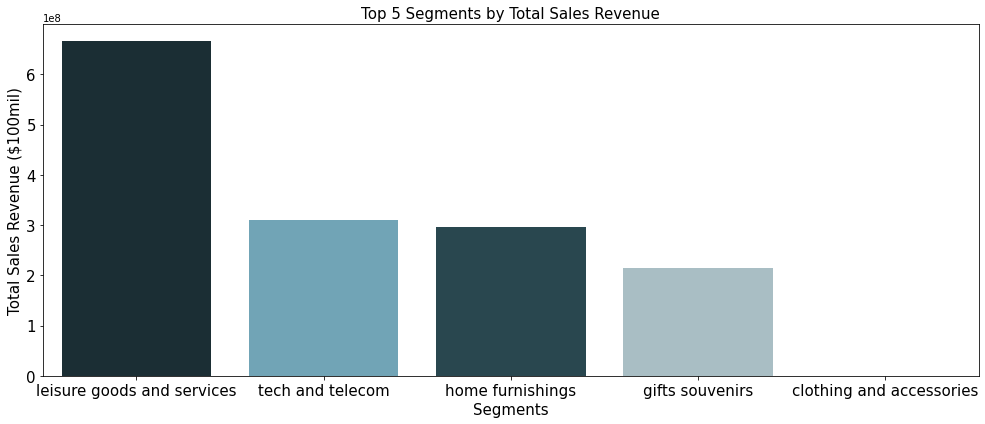

In [30]:
# Plot top 5 segments based on total sales revenue
plt.figure(figsize=(14,6))
order = segment_summary.groupby('segment').mean().sort_values('total_sales_revenue', ascending=False).index[:5]
sns.barplot(x='segment', y='total_sales_revenue', data=segment_summary, order=order, ci=False, palette=palette)
plt.xticks(fontsize=15)
plt.xlabel('Segments', fontsize=15)
plt.ylabel('Total Sales Revenue ($100mil)', fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 5 Segments by Total Sales Revenue", fontsize=15)
plt.tight_layout()
plt.savefig("plots/top_5_tot_sales_rev.png",dpi=300)

### Top 5 segments by total average daily number of orders


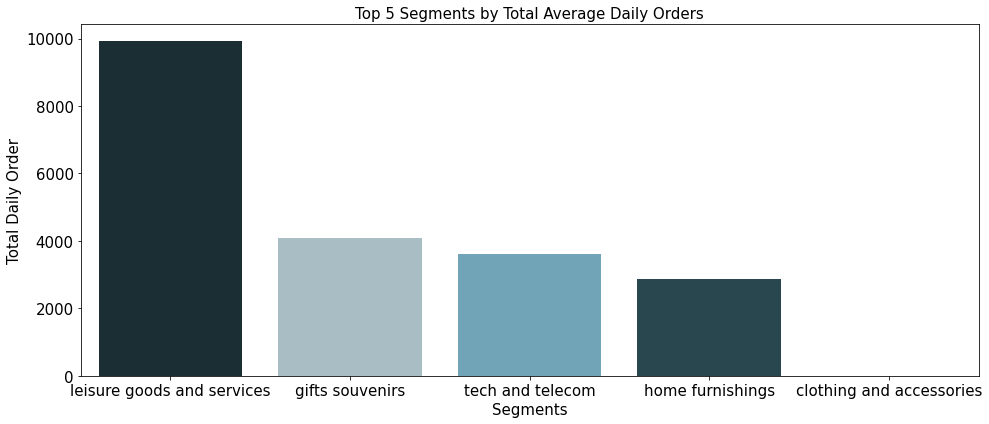

In [31]:
# Plot top 5 segments based on total average daily number of order
plt.figure(figsize=(14,6))
order = segment_summary.groupby('segment').mean().sort_values('total_avg_daily_order', ascending=False).index[:5]
sns.barplot(x='segment', y='total_avg_daily_order', data=segment_summary, order=order, ci=False, palette=palette)
plt.xticks(fontsize=15)
plt.xlabel('Segments', fontsize=15)
plt.ylabel('Total Daily Order', fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 5 Segments by Total Average Daily Orders", fontsize=15)
plt.tight_layout()
plt.savefig("plots/top_5_tot_daily_order.png",dpi=300)

### Top 5 segments by total number of orders

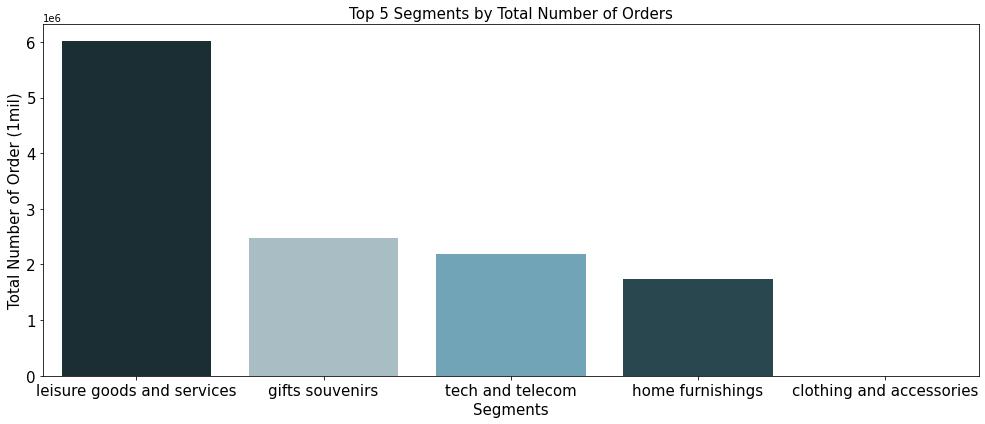

In [32]:
# Plot top 5 segments based on total number of order
plt.figure(figsize=(14,6))
order = segment_summary.groupby('segment').mean().sort_values('total_no_order', ascending=False).index[:5]
sns.barplot(x='segment', y='total_no_order', data=segment_summary, order=order, ci=False, palette=palette)
plt.xticks(fontsize=15)
plt.xlabel('Segments', fontsize=15)
plt.ylabel('Total Number of Order (1mil)', fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 5 Segments by Total Number of Orders", fontsize=15)
plt.tight_layout()
plt.savefig("plots/top_5_tot_no_order.png",dpi=300)

### Top 5 segments by total average daily commission

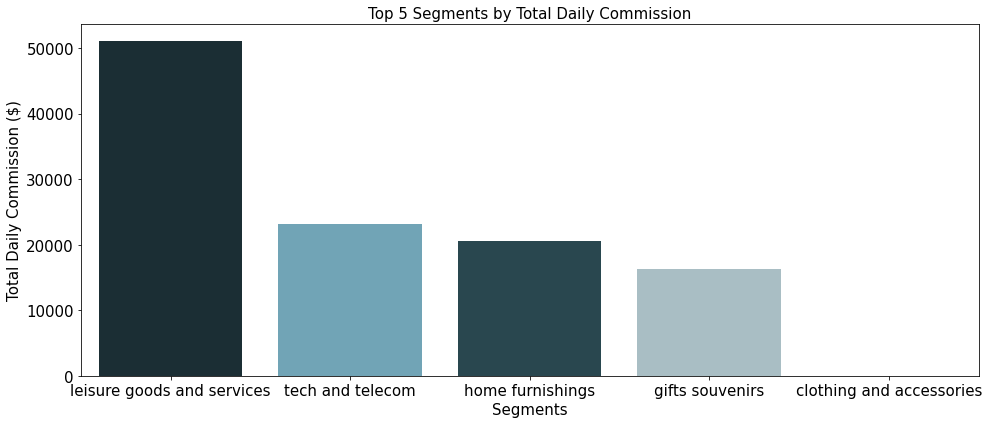

In [33]:
# Plot top 5 segments based on total daily commission
plt.figure(figsize=(14,6))
order = segment_summary.groupby('segment').mean().sort_values('total_avg_daily_commission', ascending=False).index[:5]
sns.barplot(x='segment', y='total_avg_daily_commission', data=segment_summary, order=order, ci=False, palette=palette)
plt.xticks(fontsize=15)
plt.xlabel('Segments', fontsize=15)
plt.ylabel('Total Daily Commission ($)', fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 5 Segments by Total Daily Commission", fontsize=15)
plt.tight_layout()
plt.savefig("plots/top_5_tot_daily_commission.png",dpi=300)

### Top 5 segments by average number of sales region

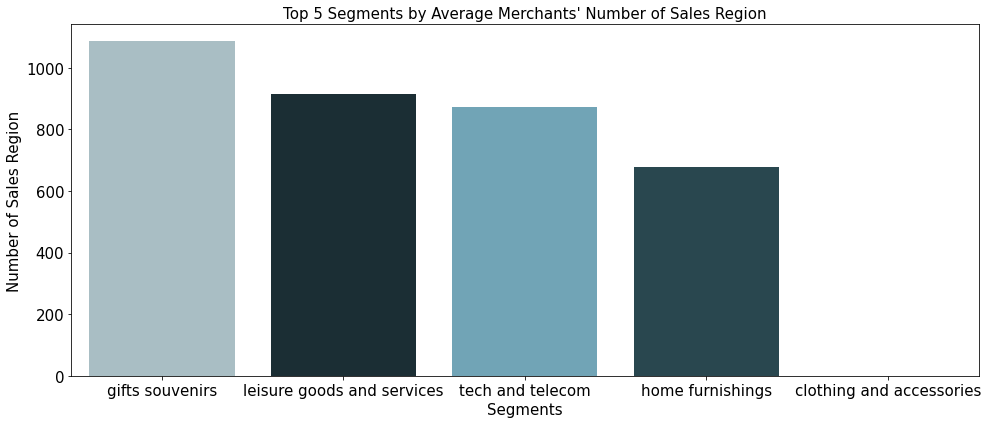

In [34]:
# Plot top 5 segments based on average merchants' number of sales region
plt.figure(figsize=(14,6))
order = segment_summary.groupby('segment').mean().sort_values('avg_no_sales_region', ascending=False).index[:5]
sns.barplot(x='segment', y='avg_no_sales_region', data=segment_summary, order=order, ci=False, palette=palette)
plt.xticks(fontsize=15)
plt.xlabel('Segments', fontsize=15)
plt.ylabel('Number of Sales Region', fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 5 Segments by Average Merchants' Number of Sales Region", fontsize=15)
plt.tight_layout()
plt.savefig("plots/top_5_avg_no_sales_region.png",dpi=300)

Based on the various segments metrics comparison plots above, we can see that `leisure goods and services`, `tech and telecom`, `home furnishings` and `gifts souvenirs` **consistently** appear as top 4 contenders.
<br>
<br>


## <a name="selections"></a>Final Selections

Based on the analysis above, coupled with forecasted growth rate in next few years of each industry. We arrived at the following selections.

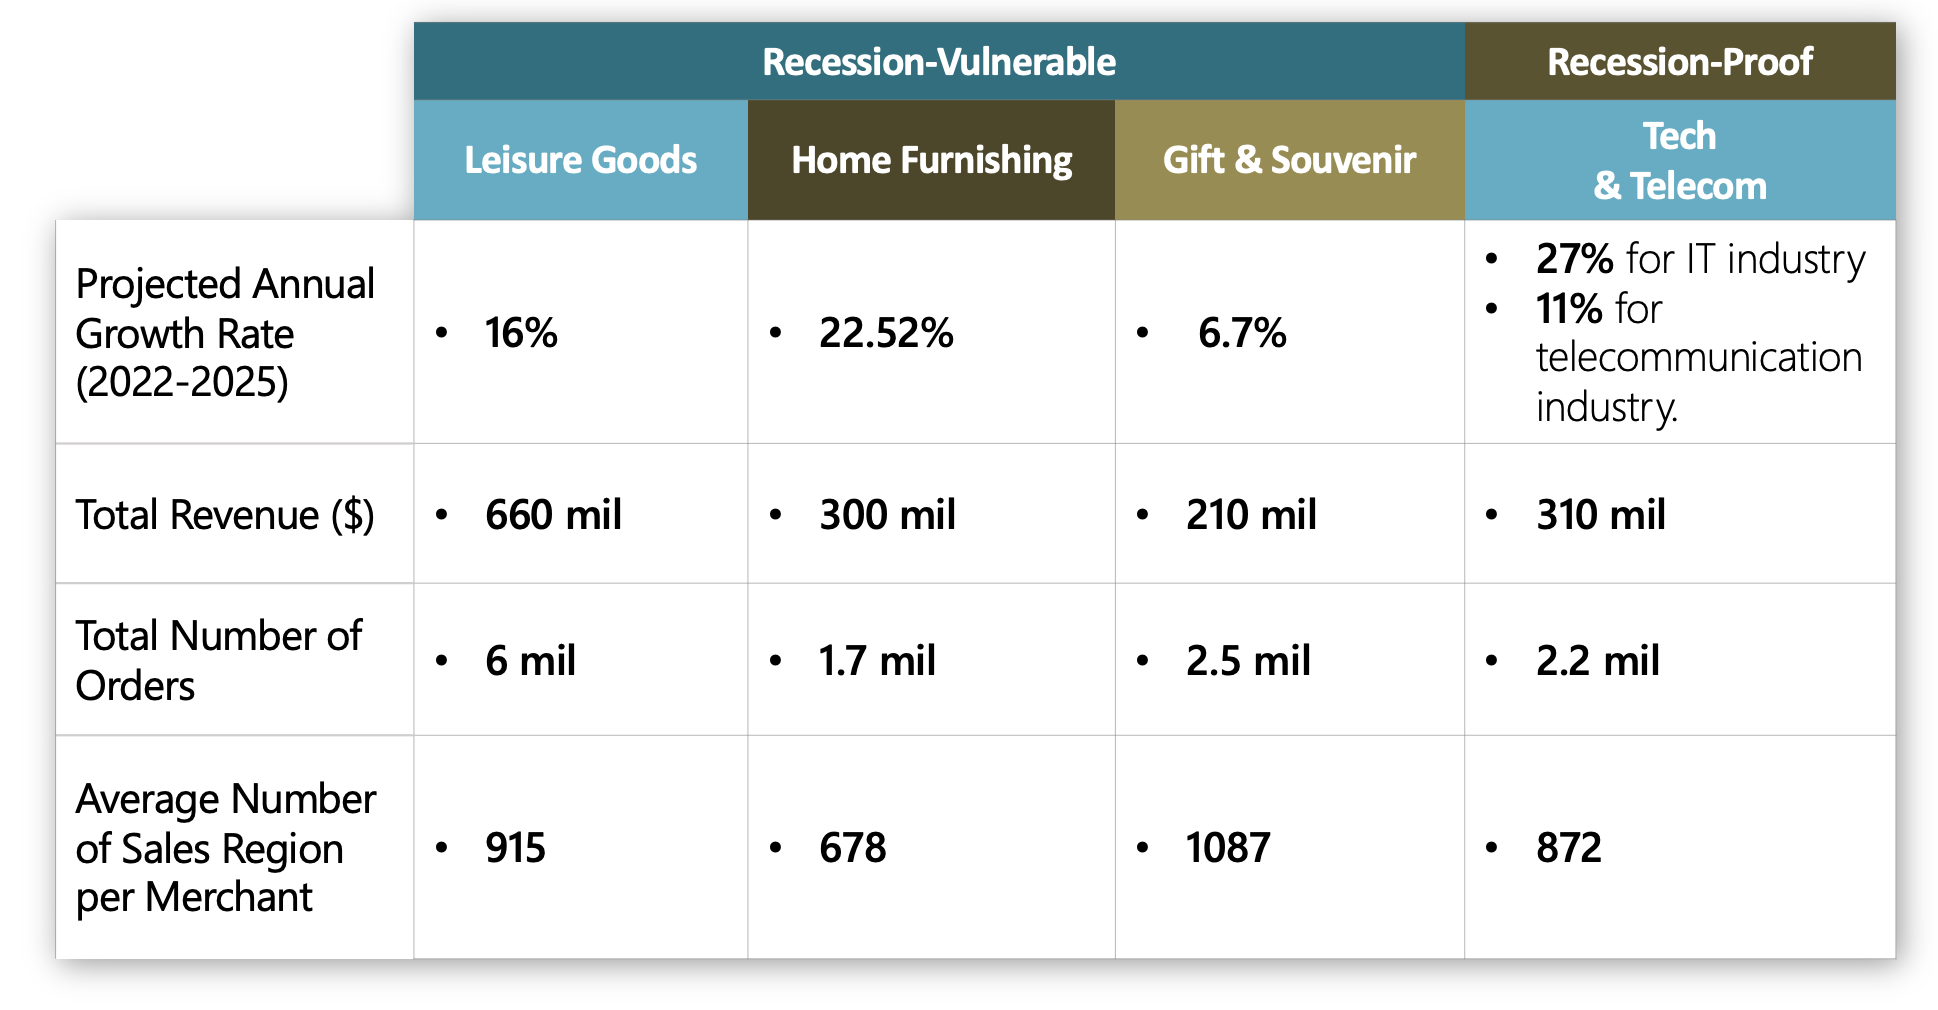
<!-- ### Recession-vulnerable 
- ### Gift & Souvenirs
    - Post-pandemic projected annual growth rate of **6.7%** ([link](https://www.marketwatch.com/press-release/personalized-gifts-market-is-estimated-to-accelerate-industry-growth-in-consumer-goods-sector-with-top-key-players-till-2028-no-of-pages-107-2022-09-28))
    - High average daily number of orders (greater exposure for the firm's growth)
    - High average daily commission
    - High number of returning customer (greater customer conversion rate)
    
- ### Leisure Goods & Services
    - Post-pandemic projected annual growth rate of **16%** ([link](https://simplywall.st/markets/us/consumer-discretionary/leisure))
    - Highest number of merchants
    - High average daily number of orders (greater exposure for the firm's growth)
    - High average daily commission
    - High number of returning customer (greater customer conversion rate)
    
- ### Home Furnishings
    - Post-pandemic projected annual growth rate of **22.52%** ([link](https://www.statista.com/outlook/dmo/ecommerce/furniture/australia))
    - High number of merchants
    - High total daily order from the segment
    - High total daily revenue from the segment
    
### Recession-proof
- ### Technology & Telecommunication
    - High post-pandemic projected annual growth rate of **27%** for IT industry overall and **11%** for telecommunication industry. ([link](https://simplywall.st/markets/au/tech))
    - High number of merchants
    - High total number of orders
    - High average daily revenue -->
    
Reference: Post-pandemic forecasted annual growth rate for [Gifts & Souvenir](https://www.marketwatch.com/press-release/personalized-gifts-market-is-estimated-to-accelerate-industry-growth-in-consumer-goods-sector-with-top-key-players-till-2028-no-of-pages-107-2022-09-28), [Leisure Goods and Services](https://simplywall.st/markets/us/consumer-discretionary/leisure), [Home Furnishings](https://www.statista.com/outlook/dmo/ecommerce/furniture/australia) and [Technology & Telecommunications](https://simplywall.st/markets/au/tech)
    
<br>
<br>
<br>

# <a name="ensemble-ranking"></a>Ensemble-Averaging Ranking Model

Our model follows a **ranking by committee model** where we apply simple min-max scaling to scale records under each metric column and output the merchants' metric value into the range of 0 to 1, while accounting for ranking direction of each metric. Then, using an **ensemble averaging** technique, for each merchant, we find the **unweighted sum of all their metrics values** as their **final output**. Finally, we rank the merchants based on their final value under this model.

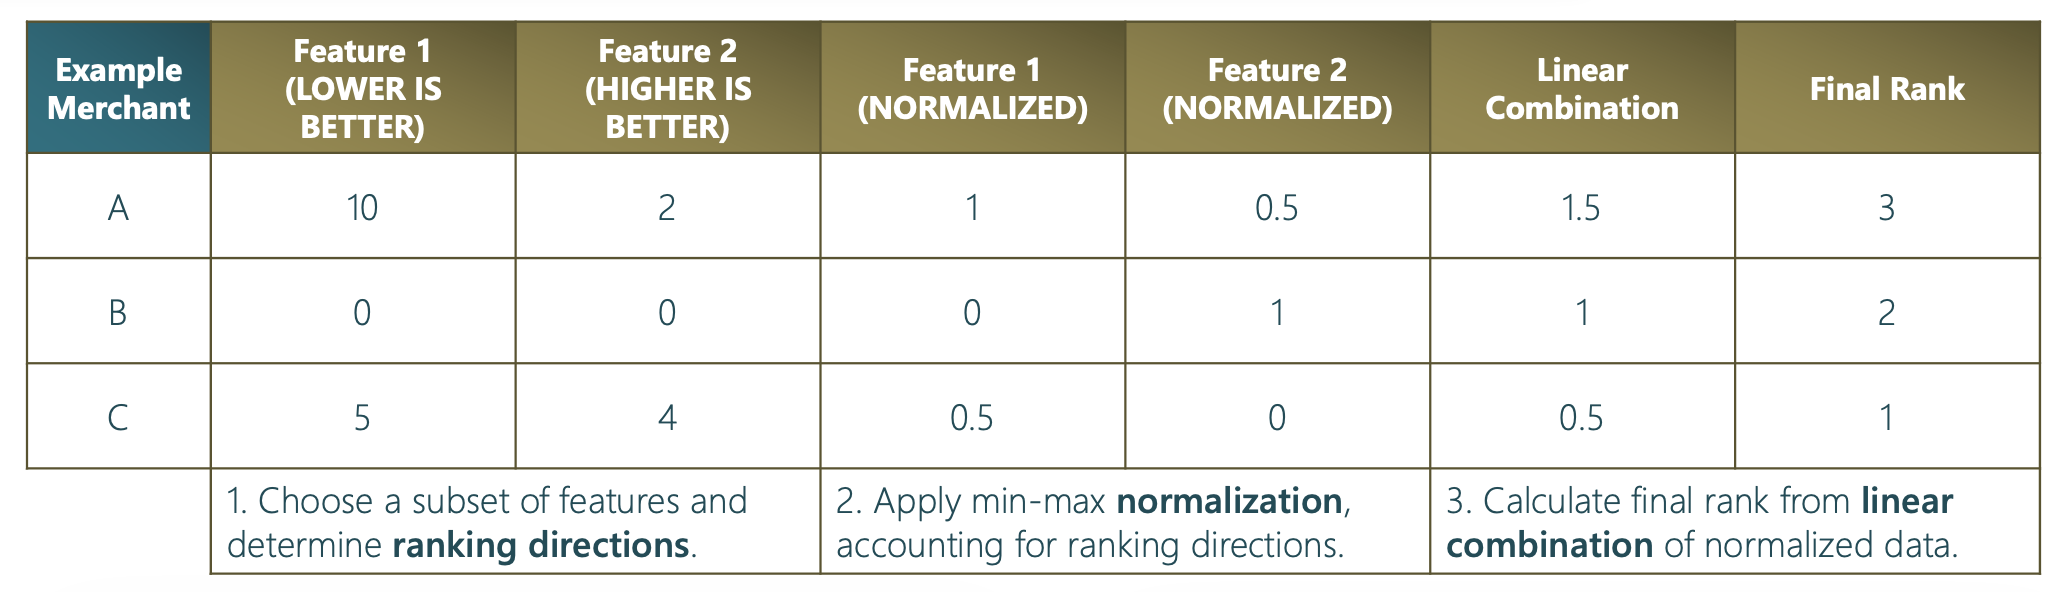

### Simple intuitions

The model essentially takes into account the **opinion of several experts** rather than relying only on one.

### Advantages
- Results are **highly interpretable**.
- Bias of each metrics is **greatly reduced**.
- **Computationally cheap** based on the size of the merchants dataset.
- Weights of each metrics **can be tailored** based on domain knowledge.

<br>
<br>

# <a name="result"></a>Top Merchants

Using the ranking model, the top 100 merchants overall as well as top 10 merchants under each segments are specified as follow


## <a name="top-100"></a>Top 100 merchants overall

In [37]:
top_100 = pd.read_csv("ranking/top-100-merchants.csv")
top_100

,overall_rank,index,merchant_abn,name,tags,tag,numd_sa2_code,returning_customers,unique_customers,median_weekly_income,...,minmax_returning_customers,minmax_unique_customers,minmax_median_weekly_income,minmax_commission_avg_tot_dollar_value_monthly,minmax_avg_num_order_id_monthly,minmax_avg_discounted_value,minmax_stddev_tot_dollar_value_monthly,minmax_rate_fraud_order,minmax_stddev_tot_discounted_value_daily,average_minmax
0,1,1926,86578477987,Leo In Consulting,"[[watch, clock, and jewelry repair shops], [a]...","watch, clock, and jewelry repair shops",2222.0,24058.0,24081.0,815.686432,...,0.000415,0.000000,0.900129,0.018045,0.056947,0.986979,0.946600,0.013724,0.696584,0.361942
1,2,148,49891706470,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",tent and awning shops,2222.0,24037.0,24078.0,815.703894,...,0.001288,0.000125,0.900125,0.334006,0.139082,0.990122,0.719540,0.010932,0.531268,0.362649
2,3,1868,63290521567,Vehicula Pellentesque Corporation,"((artist supply and craft shops), (a), (take r...",artist supply and craft shops,2222.0,23346.0,24058.0,815.663697,...,0.029998,0.000955,0.900135,0.544570,0.414380,0.991599,0.443889,0.010052,0.341655,0.367723
3,4,1327,45629217853,Lacus Consulting,"[[gift, Card, novelty, and souvenir shops], [a...","gift, card, novelty, and souvenir shops",2222.0,23945.0,24080.0,815.679442,...,0.005111,0.000042,0.900131,0.062977,0.246298,0.985203,0.858536,0.015018,0.655376,0.372869
4,5,495,89726005175,Est Nunc Consulting,"((tent and awning shops), (a), (take rate: 6.01))",tent and awning shops,2222.0,23930.0,24079.0,815.688162,...,0.005734,0.000083,0.900129,0.142732,0.249115,0.983890,0.896408,0.016425,0.666416,0.386093
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,735,89502033586,Adipiscing Enim LLC,"([digital goods: books, movies, music], [a], [...","digital goods: books, movies, music",2194.0,1158.0,13423.0,813.243970,...,0.951886,0.442608,0.900771,0.868098,0.931920,0.969153,0.138032,0.030337,0.141423,0.538684
96,97,1363,56945597985,Sem LLP,"[(caBle, satellite, and other pay television a...","cable, satellite, and other pay television and...",2192.0,822.0,12126.0,831.158631,...,0.965847,0.496470,0.896065,0.928495,0.941523,0.984196,0.069939,0.014634,0.077023,0.538770
97,98,355,35016722348,Lacus PC,"((tent and awning shops), (a), (take rate: 6.09))",tent and awning shops,2200.0,826.0,12150.0,807.355841,...,0.965681,0.495473,0.902318,0.931945,0.941067,0.983928,0.069861,0.016645,0.072421,0.538924
98,99,3962,76314317957,Semper Corp.,"([florists supplies, nursery stock, and flOwer...","florists supplies, nursery stock, and flowers",2210.0,3853.0,17971.0,811.431862,...,0.839912,0.253738,0.901247,0.526791,0.885418,0.928438,0.504603,0.064111,0.480981,0.539064


<br>

### Distributions of Top 100 Merchants

Note that some merchants have tags that belong to **multiple segments** so the following plot does not sum to 100.

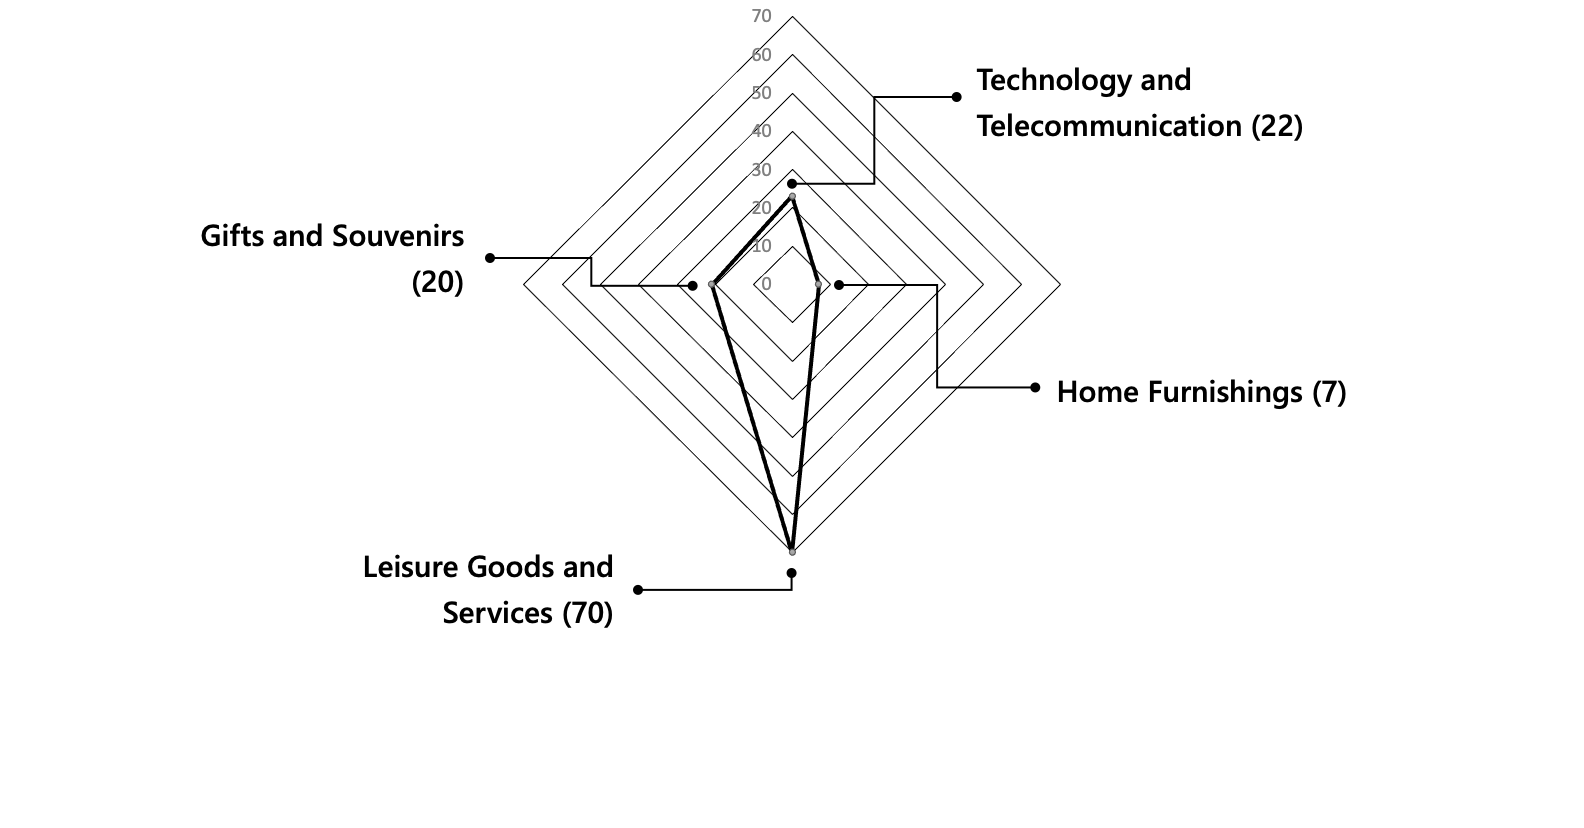


## <a name="top-10"></a>Top 10 by Segment

Merchants from certain segments will exhibit **different characteristics** inherent to the **nature of their industry**. The top 10 merchants per segment are therefore determined with weightings toward metrics that we deem are important to address issue that might arise within a segment based on the [final segment summary section](#selections).


For each metric that we prioritize, we **double the weight** (from 0.1 to 0.2). For non-priority metrics, **evenly distribute the remaining weight** to sum to 1.

### 1. Leisure Goods
   - We prioritize [**exposure-related metrics**](#exposure) since the segment's value per order is generally low but varies greatly so giving high weights on revenue comparison may not be fair.

### 2. Home Furnishings
   - The segment has **high value per order** in general and thus we would want to minimize losses due to payment default under this segment. Hence, we prioritize the [**customer demographic metrics**](#customer-demo) as an indication of the customers' ability to their repay installments.

### 3. Gifts & Souvenirs
   - This segment has relatively **high sales region coverage per merchant** (great exposure potential) already, and since the **value per order is relatively low** in this segment the risk of default payment is also relatively low. As such, for this segment, we would prioritize [**merchants' sales performance**](#sales-performance) metrics when comparing merchants under this segment.

### 4. Technology & Telecommunications
   - Similar to leisure goods segment, there is an **large variability** when it comes to **value per order** of the technology & telecommunications segment so we prioritize [**exposure-related metrics**](#exposure) as giving high weights on revenue comparison may not be fair.
 
<br>
<br>


### Top 10 gifts souvenirs merchants

In [39]:
top_segment = pd.read_csv("ranking/top-10-gifts souvenirs.csv").drop(['tags','tag'], axis=1)
top_segment

,rank_gifts_souvenirs,overall_rank,index,merchant_abn,name,numd_sa2_code,returning_customers,unique_customers,median_weekly_income,commission_avg_tot_dollar_value_monthly,...,minmax_avg_discounted_value,minmax_stddev_tot_dollar_value_monthly,minmax_rate_fraud_order,minmax_stddev_tot_discounted_value_daily,average_minmax,segment,average_minmax_gifts_souvenirs,average_minmax_home_furnishings,average_minmax_leisure_goods_and_services,average_minmax_tech_and_telecom
0,1,4,1327,45629217853,Lacus Consulting,2222.0,23945.0,24080.0,815.679442,27867.912781,...,0.985203,0.858536,0.015018,0.655376,0.372869,gifts souvenirs,0.379898,0.431454,0.213804,0.213804
1,2,7,3143,24852446429,Erat Vitae LLP,2222.0,24068.0,24080.0,815.688576,12174.827694,...,0.989478,0.869964,0.011697,0.640077,0.400202,gifts souvenirs,0.437344,0.455750,0.228693,0.228693
2,3,9,604,43186523025,Lorem Ipsum Sodales Industries,2222.0,23814.0,24076.0,815.705212,19246.311511,...,0.981987,0.914130,0.017689,0.690370,0.416937,gifts souvenirs,0.462312,0.470624,0.239787,0.239787
3,4,24,2683,32361057556,Orci In Consequat Corporation,2222.0,16653.0,23396.0,816.565756,29696.050004,...,0.949117,0.944552,0.045734,0.733512,0.461251,gifts souvenirs,0.498961,0.509990,0.311648,0.311648
4,5,23,3103,94493496784,Dictum Phasellus In Institute,2222.0,18868.0,23660.0,816.382063,24525.357742,...,0.958253,0.914937,0.038884,0.734097,0.461012,gifts souvenirs,0.512778,0.509782,0.296798,0.296798
5,6,15,1906,80324045558,Ipsum Dolor Sit Corporation,2222.0,23652.0,24070.0,815.721121,5047.509043,...,0.985262,0.716731,0.015697,0.539637,0.435535,gifts souvenirs,0.519863,0.487156,0.251412,0.251412
6,7,26,2317,79417999332,Phasellus At Company,2222.0,18813.0,23731.0,816.193086,21512.201599,...,0.958221,0.926783,0.038704,0.720937,0.470912,gifts souvenirs,0.534576,0.518588,0.302360,0.302360
7,8,29,1422,81219314324,Faucibus Leo Ltd,2222.0,8382.0,21127.0,818.312766,13512.865834,...,0.959942,0.454075,0.037251,0.368484,0.486370,gifts souvenirs,0.538522,0.532267,0.388556,0.388556
8,9,25,879,60956456424,Ultricies Dignissim LLP,2219.0,17480.0,23499.0,816.148547,17926.901282,...,0.959963,0.811389,0.036054,0.620670,0.470908,gifts souvenirs,0.539539,0.518586,0.311839,0.311839
9,10,82,1514,21772962346,Purus Gravida Sagittis Ltd,2216.0,3885.0,18185.0,813.545026,16282.665767,...,0.927193,0.513033,0.064999,0.494269,0.532217,gifts souvenirs,0.568251,0.573159,0.459286,0.459286


### Top 10 leisure goods and services merchants

In [ ]:
top_segment[top_segment['segment']=='leisure goods and services'][:10]
top_segment = pd.read_csv("ranking/top-10-leisure goods and services.csv").drop(['tags','tag'], axis=1)
top_segment

### Top 10 home furnishings merchants

In [ ]:
top_segment[top_segment['segment']=='home furnishings'][:10]

### Top 10 technology and telecommunication merchants

In [ ]:
top_segment[top_segment['segment']=='tech and telecom'][:10]

<br>
<br>

## <a name="trend"></a>Analysis on the validity of the ranking

Based on the plots below, the **general trends** of our ranking results based on **the 4 main metrics individually** follow our theoretical expectation.
<br>
<br>

### 1. Number of unique customers by rank

In [ ]:
# Plot number of unique customer trend by rank
fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.lineplot(top_100['rank'],top_100['unique_customers'], color='#234a55', sort=True)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Number of Unique Customers', fontsize=10)
ax.set_xlabel('Rank', fontsize=10)
plt.xticks(rotation=0)
plt.title("Number of Unique Customers by Rank")

fig.tight_layout()
fig.savefig('plots/top_100_unique_customers.png', dpi=300)


Based on the number of unique customers by rank plot above, it is clear that the plot shows a downward trend as rank increases. This follows closely with our expectation where the number of unique customers should progressively decrease as rank goes to 100.
<br>
<br>
<br>

### 2. Average monthly commission by rank

In [ ]:
# Plot average monthly commission trend by rank
fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.lineplot(top_100['rank'],top_100['commission_avg_tot_dollar_value_monthly'], color='#234a55', sort=True)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Average Monthly Commission ($)', fontsize=10)
ax.set_xlabel('Rank', fontsize=10)
plt.xticks(rotation=0)
plt.title("Average Monthly Commission ($AUD) by Rank")

fig.tight_layout()
fig.savefig('plots/top_100_monthly_commission.png', dpi=300)


Similarly, the plot shows a **general downward trend as rank increases** but there's much more variance this time. This happens as there exists tradeoffs in each merchant (eg. high in number of order/customers but low in take rate/commission contributed) thus we cannot have a smooth downward trend for all metrics. However, the general downward trend tells us that the ranking system follow closely with our expectation where the average monthly commission should progressively decrease as rank goes to 100. 
<br>
<br>
<br>

### 3. Overall fraud rate by rank

In [ ]:
# Plot overall fraud rate trend by rank
fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.lineplot(top_100['rank'],top_100['rate_fraud_order'], color='#234a55', sort=True)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Overall Fraud Rate', fontsize=10)
ax.set_xlabel('Rank', fontsize=10)
plt.xticks(rotation=0)
plt.title("Overall Fraud Rate by Rank")

fig.tight_layout()
fig.savefig('plots/top_100_overall_fraud_rate.png', dpi=300)


On the other hand, the overall fraud rate plot shows a **general upward trend as rank increases**, which is expected theoretically since we expect the overall merchants' fraud rate to get progressively worse as rank goes to 100.
<br>
<br>
<br>

### 4. Average monthly orders by rank

In [ ]:
# Plot number of average monthly orders trend by rank
fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.lineplot(top_100['rank'],top_100['avg_num_order_id_monthly'], color='#234a55', sort=True)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Number of Average Monthly Orders', fontsize=10)
ax.set_xlabel('Rank', fontsize=10)
plt.xticks(rotation=0)
plt.title("Number of Average Monthly Order by Rank")

fig.tight_layout()
fig.savefig('plots/top_100_avg_monthly_order.png', dpi=300)

Similar to the first two plots, the average monthly orders plot shows a **downward trend as rank increases**. This follows closely with our expectation where the number of average monthly orders should progressively decrease as rank goes to 100. 
<br>
<br>
<br>
<br>

#  <a name="limitations"></a>Assumptions, Limitations & Future Work

This section details various assumptions we've made along the project developments as well as the limitation of our model and potential future work for this project.

- ### Assumptions
    - Assume customers' weekly income **approximates** to the median personal weekly income based on their SA2 region indicated by the ABS data.
    - Commission calculations assume **100% of merchants’ consumers** use our BNPL platform for payments.
    - Features/metrics to maximize in merchants are assumed to **prioritize the prosperity and exposure** of the BNPL company only.


- ### Limitations
    - **ETL script** takes a **long time to run** (~10-20 minutes) due to the large amount of data that has to be processed.
    - Our ranking does not account for pillars of **sustainability** (no focus on social or environmental sustainability in metrics).
    - **Lack of ground truth ranking labels** makes **quantitative model evaluation difficult**. We do not yet know the preference of executives (e.g. they may prefer the firm's profit over growth, so their ground truth for rank 1 may be the highest profit firm followed by the number of orders).
    
- ### Future Work
    - Which metrics to be **weighted higher** should be discussed prior to running the ranking algorithm with the business partners or based on the company’s **future direction** (firm's growth vs shareholders' profits).
    - Collect **actual commissions earned** and **customer onboarding rate** for a certain period after selecting merchants and analyze which metrics have a high and direct impact on the actual commissions earned and customer onboarding rate and tailor this for future merchants selection.

    
<br>
<br>
<br>

# <a name="appendix"></a>Appendix

During the development of the project, we tried different methods in handling the **fraud information** and tested different ways of **ranking merchants**. However, these methods were either **too complex** or produced **unfruitful results**.

- **Merchant Fraud Probability Analysis**: Aim to identify statistics that can **separate fraudulent merchant and good merchants** based on the **p-value** (likelihood that the observed data conforms to the corresponding historical performance) against the historical distribution of each merchant. However, the **lack of data and time to conduct further research** greatly limits the feasibility of implementing this idea.<br>


- **Linear Combination Ranking with Metrics-Clustering**: Attempt to extract a subset of metrics, cluster merchants based on the subset and subsequently rank merchants based on the linear combination of the subset of metrics. This method did not work well as the **clusters are highly abstract and uninterpretable**.<br>


- **PCA Feature Selection Method**: Aim to find a **quantitative way to weight the features** we have using **PCA analysis**. The PCA method involves linearly combining all metrics to form components that capture the maximum variance in the data. We hypothesized that the importance of a feature could be measured by the sum of the absolute value of its weight in each principle component. However, due to the **lack of concrete theorematic backup** and **loss in interpretability**, we ultimately decided against this method.

For more information on the deprecated methods and research, please check out the **"appendix"** folder under the notebook folder.